In [7]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile
from scipy.signal import argrelextrema
import os

import sys
sys.path.append('../../')
from cad.calc.geo import Geo
from cad.calc.conv import freq_to_note_and_cent, note_name
import pandas as pd
import seaborn as sns


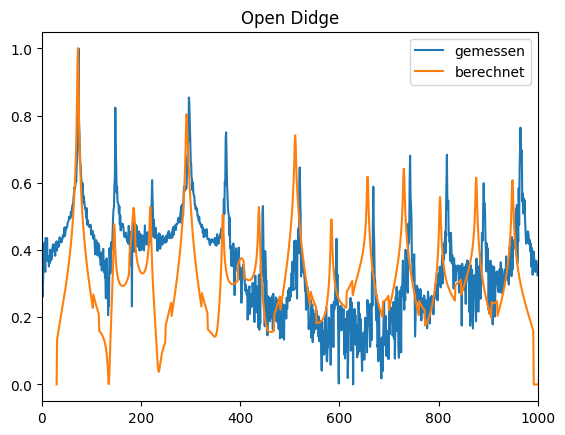

In [8]:
def do_fft(infile, size=-1, maxfreq=1000):
    sampFreq, sound = wavfile.read(infile)
    
    if len(sound.shape)==2:
        signal = sound[:,0]
    else:
        signal = sound

    if size == -1:
        size=len(signal)
    
    fft_spectrum = np.fft.rfft(signal, n=size)
    freq = np.fft.rfftfreq(size, d=1./sampFreq)
    fft_spectrum_abs = np.abs(fft_spectrum)
 
    i=0
    while i<len(freq) and freq[i]<=maxfreq:
        i+=1
    freq = freq[0:i]
    fft_spectrum_abs = fft_spectrum_abs[0:i]
    #fft_spectrum_abs = np.log2(fft_spectrum_abs)

    return freq, fft_spectrum_abs


def plot_fft(infile, size=-1):
    freq, fft_spectrum_abs = do_fft(infile)
    fft_spectrum_abs = np.log2(fft_spectrum_abs)
    plt.plot(freq, fft_spectrum_abs, label="sound")

    plt.xlim((0,1000))

    plt.xlabel("Frequency, Hz")
    plt.ylabel("Amplitude")
    plt.show()
    
from sklearn.preprocessing import MinMaxScaler

def plot_fft_and_cadsd(infile, geo, size=-1, title=None):
    
    geo = Geo(geo)
    cadsd = geo.get_cadsd()
    ground_spektrum=cadsd.get_ground_spektrum()
    ground_freqs = np.array(list(ground_spektrum.keys()))
    ground_vols = np.array(list(ground_spektrum.values()))
    #ground_vols = np.log2(ground_vols+0.0001)
    ground_vols -= ground_vols.min()
    ground_vols /= ground_vols.max()

    freq, fft_spectrum_abs = do_fft(infile, size=size)
    fft_spectrum_abs = np.log2(fft_spectrum_abs)
    fft_spectrum_abs -= fft_spectrum_abs.min()
    fft_spectrum_abs /= fft_spectrum_abs.max()

    #x = np.array(fft_spectrum_abs).reshape(-1, 1)
    #freq, fft_spectrum_abs = average_spectrum(freq, fft_spectrum_abs, window_size=10)
    #fft_spectrum_abs = np.log2(scaler.fit_transform(x)[:, 0]+0.001)
    
    #series = ["gemessen"]*len(freq)
    #df1 = pd.DataFrame(zip(freq, fft_spectrum_abs, series), columns=["freq", "impedance", "series"])

    #df = pd.concat((impedance_spectrum, df1))
    #sns.lineplot(df, x="freq", y="impedance", hue="series")
    
    plt.plot(freq, fft_spectrum_abs, label="gemessen")
    plt.plot(ground_freqs, ground_vols, label="berechnet")
    
    if title is not None:
        plt.title(title)
    plt.ylabel("")
    plt.xlim(0,1000)
    plt.legend()
    
# average the spectrum across a sliding window
def average_spectrum(freq, spectrum, window_size=100):
    new_freqs = []
    new_spectrum = []
    
    for i in np.arange(window_size, len(freq), window_size):
        new_freqs.append(freq[i])
        new_spectrum.append(np.mean(spectrum[i-window_size:i]))
    return new_freqs, new_spectrum

infile = "didgeridoo-samples/wav_short/7.wav"
geo = [[0,32], [800,32], [900,38], [970,42], [1050, 40], [1180, 48], [1350, 60], [1390, 68], [1500, 72]]
plot_fft_and_cadsd(infile, geo, title="Open Didge", size=-1)

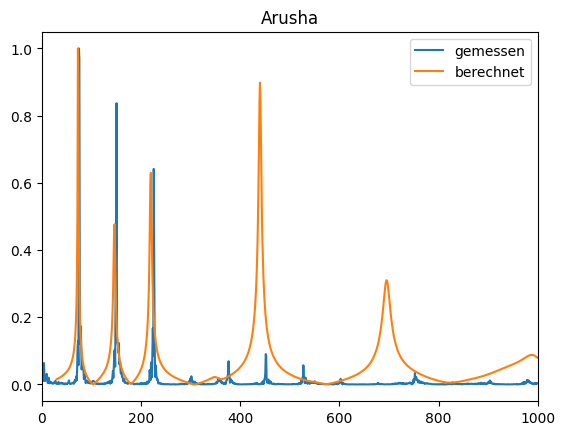

In [39]:
import json

archive_path_json = "../../../../didge-archive/didge-archive.json"
archive_path = os.path.dirname(archive_path_json)
archive = json.load(open(archive_path_json, "r"))

didge = archive[1]
geo = json.load(open(os.path.join(archive_path, didge["geometry"]), "r"))
sound_file = os.path.join(archive_path, didge["audio-samples"]["neutral-sound"])

def impedance_comparison(sound_file, geo, title=None):
    
    geo = Geo(geo)
    cadsd = geo.get_cadsd()
    
    impedance_spektrum = cadsd.get_impedance_spektrum()
    
    impedance_freqs = impedance_spektrum.freq
    impedance_amps = impedance_spektrum.impedance
    
    impedance_amps -= impedance_amps.min()
    impedance_amps /= impedance_amps.max()

    freq, fft_spectrum_abs = do_fft(sound_file)
    fft_spectrum_abs -= fft_spectrum_abs.min()
    fft_spectrum_abs /= fft_spectrum_abs.max()

    plt.plot(freq, fft_spectrum_abs, label="gemessen")
    plt.plot(impedance_freqs, impedance_amps, label="berechnet")
    
    if title is not None:
        plt.title(title)
    plt.ylabel("")
    plt.xlim(0,1000)
    plt.legend()
    
    
impedance_comparison(sound_file, geo, title=didge["name"])

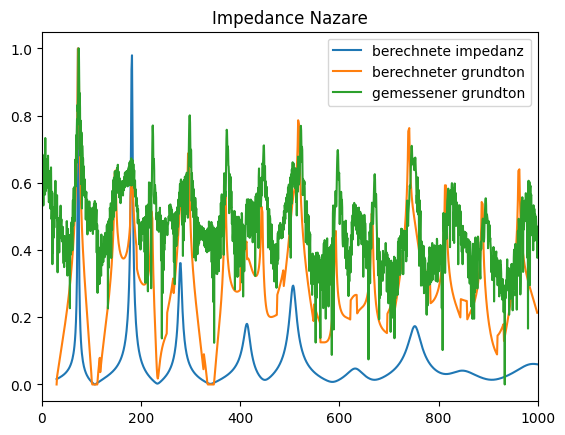

In [71]:
import json

archive_path_json = "../../../../didge-archive/didge-archive.json"
archive_path = os.path.dirname(archive_path_json)
archive = json.load(open(archive_path_json, "r"))

def comparison_plot(didge, sound_file : str, geo : list):
    
    geo = Geo(geo)
    cadsd = geo.get_cadsd()

    ground_spektrum=cadsd.get_ground_spektrum()
    ground_freqs = np.array(list(ground_spektrum.keys()))
    ground_vols = np.array(list(ground_spektrum.values()))
    ground_vols -= ground_vols.min()
    ground_vols /= ground_vols.max()
    
    impedance_spektrum = cadsd.get_impedance_spektrum()
    impedance_freqs = impedance_spektrum.freq
    impedance_amps = impedance_spektrum.impedance
    
    impedance_amps -= impedance_amps.min()
    impedance_amps /= impedance_amps.max()

    freq, fft_spectrum_abs = do_fft(sound_file)
    fft_spectrum_abs = np.log2(fft_spectrum_abs)
    fft_spectrum_abs -= fft_spectrum_abs.min()
    fft_spectrum_abs /= fft_spectrum_abs.max()
    
    plt.plot(impedance_freqs, impedance_amps, label="berechnete impedanz")
    plt.plot(ground_freqs, ground_vols, label="berechneter grundton")
    plt.plot(freq, fft_spectrum_abs, label="gemessener grundton")
    
    plt.title("Impedance " + didge["name"])
    plt.ylabel("")
    plt.xlim(0,1000)
    plt.legend()
    plt.show()

didge = archive[2]
geo = json.load(open(os.path.join(archive_path, didge["geometry"]), "r"))
sound_file = os.path.join(archive_path, didge["audio-samples"]["neutral-sound"])


comparison_plot(didge, sound_file, geo)    

Nazare


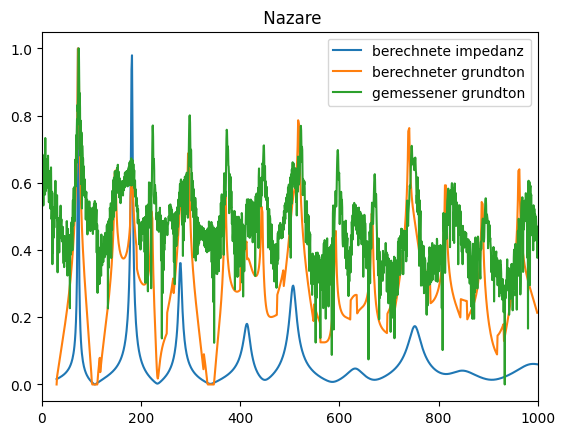

In [75]:
import json

archive_path_json = "../../../../didge-archive/didge-archive.json"
archive_path = os.path.dirname(archive_path_json)
archive = json.load(open(archive_path_json, "r"))

def get_maxima(freq, signal, n):
    
    if type(freq) is not np.array:
        freq = np.array(freq)
    if type(signal) is not np.array:
        signal = np.array(signal)
    
    max_indizes = np.array(argrelextrema(signal, np.greater)[0])
    max_indizes = sorted(max_indizes, key=lambda x : signal[x])
    i_maxima = max_indizes[-1*n:]
    maxima = [freq[m] for m in i_maxima]
    #maxima = sorted(maxima)
    return maxima, i_maxima

def compute_difference(sound_file : str, geo : list, didge_name=None):
    
    geo = Geo(geo)
    cadsd = geo.get_cadsd()

    ground_spektrum=cadsd.get_ground_spektrum()
    ground_freqs = np.array(list(ground_spektrum.keys()))
    ground_vols = np.array(list(ground_spektrum.values()))
    ground_vols -= ground_vols.min()
    ground_vols /= ground_vols.max()
    
    impedance_spektrum = cadsd.get_impedance_spektrum()
    impedance_freqs = impedance_spektrum.freq
    impedance_amps = impedance_spektrum.impedance
    
    impedance_amps -= impedance_amps.min()
    impedance_amps /= impedance_amps.max()

    freq, fft_spectrum_abs = do_fft(sound_file)
    fft_spectrum_abs = np.log2(fft_spectrum_abs)
    fft_spectrum_abs -= fft_spectrum_abs.min()
    fft_spectrum_abs /= fft_spectrum_abs.max()
    
    plt.plot(impedance_freqs, impedance_amps, label="berechnete impedanz")
    plt.plot(ground_freqs, ground_vols, label="berechneter grundton")
    plt.plot(freq, fft_spectrum_abs, label="gemessener grundton")
    
    title = ""
    if didge_name is not None:
        title += " " + str(didge_name)
    plt.title(title)
    plt.ylabel("")
    plt.xlim(0,1000)
    plt.legend()
    plt.show()

    
didge = archive[2]
geo = json.load(open(os.path.join(archive_path, didge["geometry"]), "r"))
sound_file = os.path.join(archive_path, didge["audio-samples"]["neutral-sound"])

print(didge["name"])
compute_difference(sound_file, geo, didge_name=didge["name"])    

,freq,note_number,note,cent_diff,amp
0,68.753590,-32,C#1,13.595889,21.880596
11,74.181505,-31,D1,-17.953500,27.609041
9,148.363010,-19,D2,-17.953500,25.028634
2,293.107410,-7,D3,3.288902,22.862991
6,294.916715,-7,D3,-7.364880,23.584495
10,296.726020,-7,D3,-17.953500,25.471798
7,371.812177,-3,F#3,-8.484595,23.956617
1,520.175187,3,C4,10.207130,22.424003
3,742.719701,9,F#4,-6.377189,22.934783
4,816.901206,11,G#4,28.810293,22.977504


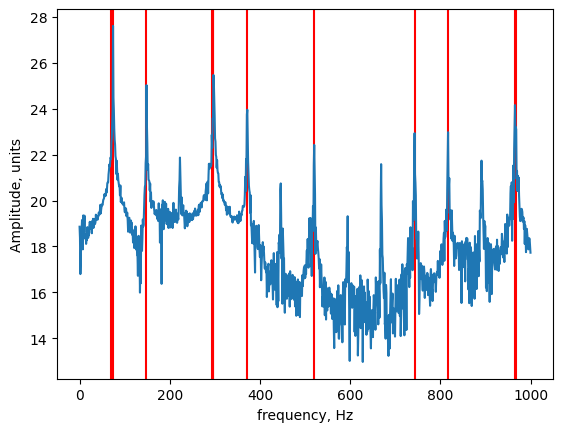

In [72]:
def minmax(x):
    return x


infile = "didgeridoo-samples/wav_short/7.wav"
freq, spectrum = do_fft(infile)
spectrum = minmax(np.log2(spectrum))
#freq, spectrum = average_spectrum(freq, spectrum, window_size=100)

def get_maxima(freq, signal, n):
    
    if type(freq) is not np.array:
        freq = np.array(freq)
    if type(signal) is not np.array:
        signal = np.array(signal)
    
    max_indizes = np.array(argrelextrema(signal, np.greater)[0])
    max_indizes = sorted(max_indizes, key=lambda x : signal[x])
    i_maxima = max_indizes[-1*n:]
    maxima = [freq[m] for m in i_maxima]
    #maxima = sorted(maxima)
    return maxima, i_maxima

maxima, i_maxima = get_maxima(freq, spectrum, 12)
for m in maxima:
    plt.axvline(x=m, color="red")

plt.plot(freq, spectrum)
plt.xlabel("frequency, Hz")
plt.ylabel("Amplitude, units")

df = []
for i in range(len(maxima)):
    note_number, cent_diff = freq_to_note_and_cent(maxima[i])
    df.append([maxima[i], note_number, note_name(note_number), cent_diff, spectrum[i_maxima[i]]])

df = pd.DataFrame(df, columns=["freq", "note_number", "note", "cent_diff", "amp"]).sort_values(by=["freq"])
df

In [ ]:
def get_overtones_from_wav(infile):
    freq, fft_spectrum_abs = do_fft(infile)
    maxima, i_maxima = get_maxima(freq, fft_spectrum_abs, 10)
    df = []
    for i in range(len(maxima)):
        note_number, cent_diff = freq_to_note_and_cent(maxima[i])
        df.append([maxima[i], note_number, note_name(note_number), cent_diff, fft_spectrum_abs[i_maxima[i]]])

    df = pd.DataFrame(df, columns=["freq", "note_number", "note", "cent_diff", "amp"])
    return df



In [ ]:
infile = "didgeridoo-samples/wav_short/7.wav"
freq, spectrum = do_fft(infile)

def get_maxima(freq, signal, n):
    max_indizes = np.array(argrelextrema(fft_spectrum_abs, np.greater)[0])
    max_indizes = sorted(max_indizes, key=lambda x : fft_spectrum_abs[x])
    i_maxima = max_indizes[-1*n:]
    maxima = [freq[m] for m in i_maxima]
    maxima = sorted(maxima)
    return maxima, i_maxima

maxima, _ = get_maxima(freq, spectrum, 10)
for m in maxima:
    plt.axvline(x=m, color="red")

plt.xlim((0,1000))

plt.plot(freq, spectrum)
plt.xlabel("frequency, Hz")
plt.ylabel("Amplitude, units")

plt.show()

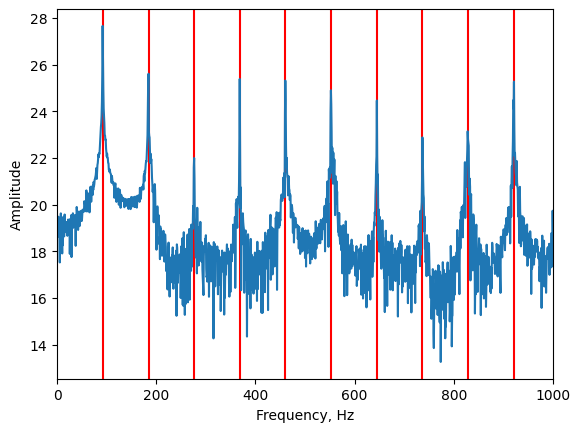

'{"note": {"0": "F#1", "1": "F#2", "9": "C#3", "2": "F#3", "3": "A#4", "5": "C#4", "6": "E4", "8": "F#4", "7": "G#4", "4": "A#5"}, "cent-diff": {"0": 10.976304776706769, "1": 4.430988666177171, "9": 4.6550114353010486, "2": 7.700553470020566, "3": 22.041494197620892, "5": 6.836781162076733, "6": 38.40718809456689, "8": 7.700553470020566, "7": 5.609648312064053, "4": 20.732432472438944}, "freq": {"0": 91.91400470014798, "1": 184.52432761772133, "9": 276.4383323178693, "2": 368.3523370180173, "3": 460.2663417181653, "5": 552.1803464183132, "6": 644.7906693358866, "8": 736.7046740360346, "7": 827.9223605187572, "4": 921.2290016537559}, "impedance": {"0": 212703466.9937342, "1": 51360481.26009979, "9": 4189237.0021876707, "2": 43956280.82140037, "3": 41948922.38472426, "5": 31435813.59818078, "6": 23187543.30085413, "8": 7746036.080585161, "7": 9296255.857709624, "4": 40586857.56672239}}'

In [82]:
# get peaks in fft
def get_n_peaks(freq, spectrum, n=10):
    # get all maxima
    peaks = []
    rising = True
    
    #spectrum = [0,1,2,1,0,1,0]
    #freq = np.arange(len(spectrum))
    
    for i in range(1,len(spectrum)):
        if spectrum[i]<spectrum[i-1] and rising:
            rising = False
            peaks.append(i-1)
        if spectrum[i]>spectrum[i-1]:
            rising = True
            
    # get n highest maxima
    peaks = sorted(peaks, key=lambda x : spectrum[x], reverse=True)
    df = []
    for i in range(n):
        f = freq[peaks[i]]
        note, cent = freq_to_note_and_cent(f)
        imp = spectrum[peaks[i]]
        
        skip = False
        for j in range(len(df)):
            if np.abs(np.log2(df[j][2])-np.log2(f))<0.15:
                if imp>df[j][3]:
                    del df[j]
                    break
                else:
                    skip = True
                    break
        
        if not skip:
            df.append([note_name(note), cent, f, imp])
    
    df = pd.DataFrame(df, columns=["note", "cent-diff", "freq", "impedance"])
    
    
    
    return df
infile = "didgeridoo-samples/wav_short/4.wav"
freq, spectrum = do_fft(infile)
maxima = get_n_peaks(freq, spectrum, n=20).sort_values(by=["freq"])
maxima

infile = "didgeridoo-samples/wav_short/4.wav"
freq, fft_spectrum_abs=do_fft(infile)
freq, fft_spectrum_abs = do_fft(infile)
fft_spectrum_abs = np.log2(fft_spectrum_abs)

def get_maxima(freq, signal, n):

    max_indizes = np.array(argrelextrema(fft_spectrum_abs, np.greater)[0])
    max_indizes = sorted(max_indizes, key=lambda x : fft_spectrum_abs[x])
    i_maxima = max_indizes[-1*n:]
    maxima = [freq[m] for m in i_maxima]
    maxima = sorted(maxima)
    return maxima, i_maxima


#for m in get_maxima(freq, np.exp(fft_spectrum_abs), 20)[0]:
for m in maxima.freq:
    plt.axvline(x=m, color="red")

plt.plot(freq, fft_spectrum_abs, label="sound")

plt.xlim((0,1000))

plt.xlabel("Frequency, Hz")
plt.ylabel("Amplitude")
plt.show()

maxima.to_csv("maxima_4.csv")

import json
json.dumps(maxima.to_dict())

In [102]:
from cad.calc.loss import LossFunction

class BlackEucaLoss(LossFunction):

    def __init__(self):
        self.reference = '{"note": {"0": "F#1", "1": "F#2", "9": "C#3", "2": "F#3", "3": "A#4", "5": "C#4", "6": "E4", "8": "F#4", "7": "G#4", "4": "A#5"}, "cent-diff": {"0": 10.976304776706769, "1": 4.430988666177171, "9": 4.6550114353010486, "2": 7.700553470020566, "3": 22.041494197620892, "5": 6.836781162076733, "6": 38.40718809456689, "8": 7.700553470020566, "7": 5.609648312064053, "4": 20.732432472438944}, "freq": {"0": 91.91400470014798, "1": 184.52432761772133, "9": 276.4383323178693, "2": 368.3523370180173, "3": 460.2663417181653, "5": 552.1803464183132, "6": 644.7906693358866, "8": 736.7046740360346, "7": 827.9223605187572, "4": 921.2290016537559}, "impedance": {"0": 212703466.9937342, "1": 51360481.26009979, "9": 4189237.0021876707, "2": 43956280.82140037, "3": 41948922.38472426, "5": 31435813.59818078, "6": 23187543.30085413, "8": 7746036.080585161, "7": 9296255.857709624, "4": 40586857.56672239}}'
        self.reference = pd.DataFrame(json.loads(self.reference))        
        self.reference["impedance_normalized"] = self.reference.impedance / self.reference.impedance.max()
        self.reference["logfreq"] = np.log2(self.reference.freq)
        
    def get_loss(self, geo):
        peaks = geo.get_cadsd().get_notes()
        peaks["logfreq"] = np.log2(peaks.freq)
        peaks["impedance_normalized"] = peaks.impedance / peaks.impedance.max()
        
        tuning_loss = []
        imp_loss = []
        for ix, peak in peaks.iterrows():
            mini = np.argmin([np.abs(peak.logfreq-f) for f in self.reference.logfreq])
            
            tl = np.abs(peak.logfreq-self.reference.logfreq[mini])
            il = np.abs(peak.impedance_normalized - self.reference.impedance_normalized[mini])
            tuning_loss.append(tl)
            imp_loss.append(il)
            # print(f"{self.reference.freq[mini]:.0f}, {peak.freq:.0f}, {tl:.2f}, {il:.2f}")

        fundamental_loss = tuning_loss[0]*10
        tuning_loss = np.sum(tuning_loss)
        imp_loss = np.sum(imp_loss)
        
        return {
            "loss": fundamental_loss + tuning_loss + imp_loss,
            "fundamental_loss": fundamental_loss,
            "tuning_loss": tuning_loss,
            "imp_loss": imp_loss
        }
    
geo = [[0,32], [800,32], [900,38], [970,42], [1050, 40], [1180, 48], [1350, 60], [1390, 68], [1500, 72]]
geo=Geo(geo)
EucaLoss().get_loss(geo)

{'loss': 4.826852912240933,
 'fundamental_loss': 3.3832933384517094,
 'tuning_loss': 0.7992758726208375,
 'imp_loss': 0.6442837011683864}

In [122]:
freq

array([0.00000000e+00, 1.05999423e+00, 2.11998846e+00, ...,
       2.20478800e+04, 2.20489400e+04, 2.20500000e+04])

In [28]:
!ls didgeridoo-samples/wav_short/7.wav

didgeridoo-samples/wav_short/7.wav


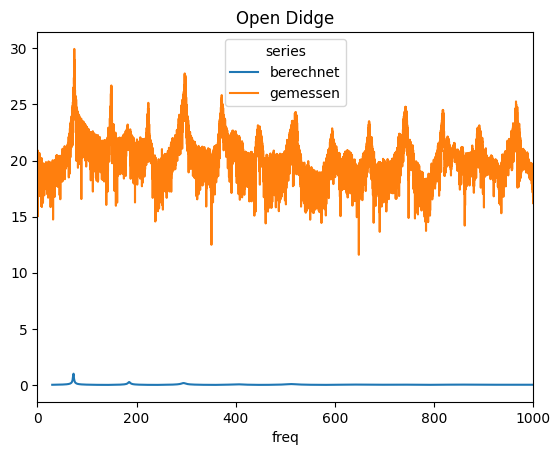

In [133]:
infile = "didgeridoo-samples/wav_short/7.wav"
geo = [[0,32], [800,32], [900,38], [970,42], [1050, 40], [1180, 48], [1350, 60], [1390, 68], [1500, 72]]
plot_fft_and_cadsd(infile, geo, title="Open Didge")

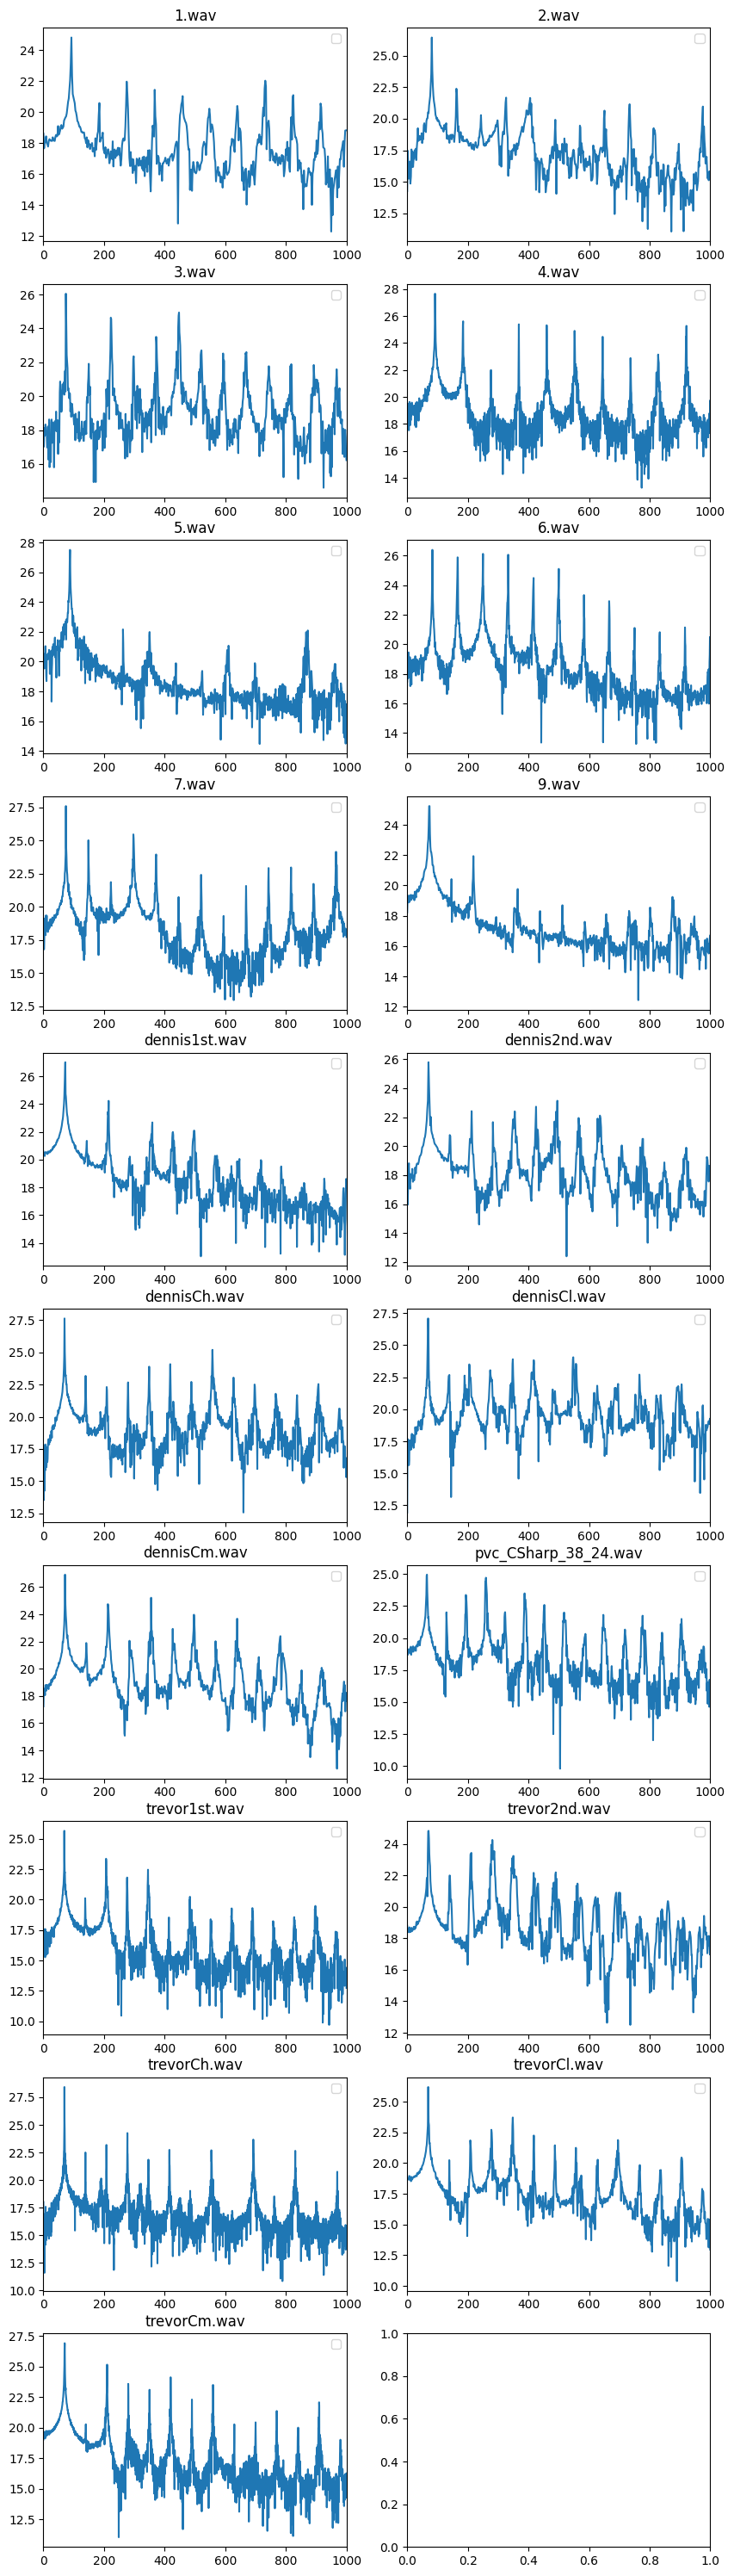

In [8]:
path = "didgeridoo-samples/wav_short"
infiles = sorted(os.listdir(path))
infiles = list(filter(lambda x : x != ".DS_Store" and os.path.isfile(os.path.join(path, x)), infiles))

fig, axs = plt.subplots(np.ceil(len(infiles)/2).astype(int), 2, figsize=(10,len(infiles)*2))
for i in range(len(infiles)):
    row=int(i/2)
    column=i%2
    infile = infiles[i]
    freq, fft_spectrum_abs = do_fft(os.path.join(path, infile))
    fft_spectrum_abs = np.log2(fft_spectrum_abs)
    ax = axs[row][column]
    ax.plot(freq, fft_spectrum_abs, label="sound")
    ax.set_title(infile)
    ax.set_xlim((0,1000))
    ax.legend("")


In [47]:
print(len(x))

290616


In [27]:
from __future__ import print_function

import os.path

from google.auth.transport.requests import Request
from google.oauth2.credentials import Credentials
from google_auth_oauthlib.flow import InstalledAppFlow
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError

# If modifying these scopes, delete the file token.json.
SCOPES = ['https://www.googleapis.com/auth/spreadsheets.readonly']

# The ID and range of a sample spreadsheet.
SAMPLE_SPREADSHEET_ID = '16_tkHuyBDrFTOWlu4-UH1QM4oBGv72GPem8N4IvthxI'
SAMPLE_RANGE_NAME = 'Class Data!A2:E'


def main():
    """Shows basic usage of the Sheets API.
    Prints values from a sample spreadsheet.
    """
    creds = None
    # The file token.json stores the user's access and refresh tokens, and is
    # created automatically when the authorization flow completes for the first
    # time.
    if os.path.exists('token.json'):
        creds = Credentials.from_authorized_user_file('token.json', SCOPES)
    # If there are no (valid) credentials available, let the user log in.
    if not creds or not creds.valid:
        if creds and creds.expired and creds.refresh_token:
            creds.refresh(Request())
        else:
            flow = InstalledAppFlow.from_client_secrets_file(
                'credentials.json', SCOPES)
            creds = flow.run_local_server(port=0)
        # Save the credentials for the next run
        with open('token.json', 'w') as token:
            token.write(creds.to_json())

    try:
        service = build('sheets', 'v4', credentials=creds)

        # Call the Sheets API
        sheet = service.spreadsheets()
        result = sheet.values().get(spreadsheetId=SAMPLE_SPREADSHEET_ID,
                                    range=SAMPLE_RANGE_NAME).execute()
        values = result.get('values', [])

        if not values:
            print('No data found.')
            return

        print('Name, Major:')
        for row in values:
            # Print columns A and E, which correspond to indices 0 and 4.
            print('%s, %s' % (row[0], row[4]))
    except HttpError as err:
        print(err)


if __name__ == '__main__':
    main()


<HttpError 400 when requesting https://sheets.googleapis.com/v4/spreadsheets/16_tkHuyBDrFTOWlu4-UH1QM4oBGv72GPem8N4IvthxI/values/Class%20Data%21A2%3AE?alt=json returned "Unable to parse range: Class Data!A2:E". Details: "Unable to parse range: Class Data!A2:E">


In [ ]:
from __future__ import print_function

import os.path

from google.auth.transport.requests import Request
from google.oauth2.credentials import Credentials
from google_auth_oauthlib.flow import InstalledAppFlow
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError

# If modifying these scopes, delete the file token.json.
SCOPES = ['https://www.googleapis.com/auth/spreadsheets.readonly']

# The ID and range of a sample spreadsheet.
SAMPLE_SPREADSHEET_ID = '16_tkHuyBDrFTOWlu4-UH1QM4oBGv72GPem8N4IvthxI'
SAMPLE_RANGE_NAME = 'Class Data!A2:E'


In [4]:
!pip install gspread

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 853.1 kB/s eta 0:00:00 0:00:01


In [15]:
import gspread
import json

credentials = json.load(open("service_account.json", "r"))

gc = gspread.service_account("service_account.json")

# Open a sheet from a spreadsheet in one go
wks = gc.open_by_key("16_tkHuyBDrFTOWlu4-UH1QM4oBGv72GPem8N4IvthxI").sheet1

# Update a range of cells using the top left corner address
wks.update('A1', [[1, 2], [3, 4]])

# Or update a single cell
wks.update('B42', "it's down there somewhere, let me take another look.")

# Format the header
wks.format('A1:B1', {'textFormat': {'bold': True}})


/Users/jane03/miniconda3/lib/python3.10/site-packages/gspread/worksheet.py:1046: UserWarning: [Deprecated][in version 6.0.0]: method signature will change to: 'Worksheet.update(value = [[]], range_name=)' arguments 'range_name' and 'values' will swap, values will be mandatory of type: 'list(list(...))'
  warnings.warn(


{'spreadsheetId': '16_tkHuyBDrFTOWlu4-UH1QM4oBGv72GPem8N4IvthxI',
 'replies': [{}]}

In [8]:
# didgelab database to table
headings = ["ID", "File", "Comment", "Fundamental-Note"]


{'installed': {'client_id': '616465563771-kuepefsk40lqnsnl3i2rdfdbpe2opjhq.apps.googleusercontent.com',
  'project_id': 'mds-test-aqpd',
  'auth_uri': 'https://accounts.google.com/o/oauth2/auth',
  'token_uri': 'https://oauth2.googleapis.com/token',
  'auth_provider_x509_cert_url': 'https://www.googleapis.com/oauth2/v1/certs',
  'client_secret': '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',
  'redirect_uris': ['http://localhost']}}